In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import pickle
import implicit
from scipy.sparse import csr_matrix
import glob

In this notebook, we use the collaborative filtering model by importing the implicit package in python.
Because collaborative filtering requires a large user pool, we trained the model using the first 31,000 playlists to ensure consistency of the project and reduce running time. However, by increasing the size of traing set, our model accuracy could be further improved 

In [2]:
# path = "Songs/"
# all_files = glob.glob(path + "/*.csv")

# def rank(path):
#     return int(path.split('/')[1].split('.')[0][5:])

# all_files = sorted(all_files, key=rank)
# all_files = all_files[:100]
# li = []
# pid_base = 0
# for filename in all_files:
#     df = pd.read_csv(filename, index_col=None)
#     df['pid'] = df['pid'] + pid_base
#     li.append(df)
#     pid_base += 1000

# df = pd.concat(li, axis=0, ignore_index=True)
df = pd.read_csv('first30.csv')

In [3]:
df.head()

,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,0.904,0.813,4.0,-7.105,0.0,0.1210,0.03110,0.006970,0.0471,0.810,125.461
1,0,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone,0.774,0.838,5.0,-3.914,0.0,0.1140,0.02490,0.025000,0.2420,0.924,143.040
2,0,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit),0.664,0.758,2.0,-6.583,0.0,0.2100,0.00238,0.000000,0.0598,0.701,99.259
3,0,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified,0.891,0.714,4.0,-6.055,0.0,0.1400,0.20200,0.000234,0.0521,0.818,100.972
4,0,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot,0.853,0.606,0.0,-4.596,1.0,0.0713,0.05610,0.000000,0.3130,0.654,94.759


To use collaborative filtering, we discard all features, only leaving three columns: user, song, and ratings. Collaborative filtering is based on the idea that the features will be incorporated in each user's individual choice. For ratings, because we don't have specific numbers, we choose 1 for 'included in playlist' and leave the field blank otherwise.

In [4]:
df_new = pd.DataFrame(columns = ['user', 'song', 'ratings'])

In [5]:
users = df['pid']
tracks = df['track_uri'].unique()
songs_dict = {tracks[i]: i for i in range(len(tracks))}
songs = [songs_dict[s] for s in df['track_uri']]
ratings = np.ones(len(users))

In [6]:
df_new.user = users
df_new.song = songs
df_new.ratings = ratings

In [7]:
df_new.head()

,user,song,ratings
0,0,0,1.0
1,0,1,1.0
2,0,2,1.0
3,0,3,1.0
4,0,4,1.0


Next, we split each playlist into train (the first 80%) and test (the last 20%). The below functions will establish a training dataset from the original one.

In [8]:
def train_test_split(df, size=0.2):
    train = []
    test = []
    for i in range(len(df.user.unique())):
        indices = np.array(df[df['user']==i].index)
        train_indices = range(indices[0], indices[len(indices)//10*8])
        train += train_indices
    return df.iloc[train]

In [9]:
train = train_test_split(df_new)

In [10]:
train.head()

,user,song,ratings
0,0,0,1.0
1,0,1,1.0
2,0,2,1.0
3,0,3,1.0
4,0,4,1.0


In order to use collaborative filtering, we use a csr matrix, which is a sparse matrix. The matrix will have every song as a row, every user as a column, and every rating as a number in the matrix. When the song is included in this user's playlist, the field is filled with a 1. Otherwise, it is left blank because we don't have information on this user's preference to this specific song. Therefore, the resulting matrix will be very large and sparse.

In [11]:
col = train.user
row = train.song
data = train.ratings

In [12]:
mtx = csr_matrix((data, (row, col)))
mtx

<344488x31000 sparse matrix of type '<class 'numpy.float64'>'
	with 1533880 stored elements in Compressed Sparse Row format>

Now, a model is trained using the Alternating Least Squares approach in collaborative filtering.

In [13]:
# initialize a model
model = implicit.als.AlternatingLeastSquares()

# train the model on a sparse matrix of item/user/confidence weights
model.fit(mtx)
# find related items
# related = model.similar_items(itemid)

To evaluate the model's performance, we use the same metric, which is r-precision

In [14]:
def eval_playlist(test_tracks, recommended_tracks): #r-precision
    test = set(test_tracks)
    pred = set(recommended_tracks)
    res = list(test & pred)
    return len(res) / len(test)

Now, we run through the first 1000 users to generate recommendations of length n (n being the size of the training dataset) and evaluate the model.

In [15]:
scores = []
for user in range(1000):
    # recommend items for a user
    #user_items = mtx.T.tocsr()
    try:
        recommendations = [i[0] for i in model.recommend(user, mtx[:,user], N = mtx[:,user].getnnz())]

        indices = np.array(df_new[df_new['user']==user].index)
        test_indices = range(indices[len(indices)//10*8],indices[-1]+1)
        test_tracks = df_new.iloc[test_indices].song

        scores.append(eval_playlist(test_tracks, recommendations))
    except:
        pass

In [16]:
print("In the end, the ALS collaborative filtering model achieved a mean score of: ", np.mean(scores))

In the end, the ALS collaborative filtering model achieved a mean score of:  0.07801972197062193


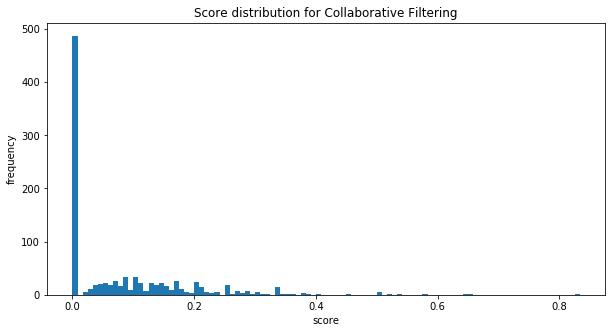

In [17]:
plt.subplots(figsize = (10,5))
plt.hist(scores,bins=100)
plt.title('Score distribution for Collaborative Filtering')
plt.xlabel('score')
plt.ylabel('frequency')
plt.show()

From the histogram, we could see that most playlist (about half) has a score of 0, which is expected because of the size of playlists and validation sets. Then, a majority of playlist achieved a score around 10%. And the best performing playlists could achieve scores of 80% or more. This is a very good model and a great improvement from the baseline model.